In [43]:
import numpy as np
from scipy.integrate import solve_bvp
from numpy import linalg as LA
import math
from scipy.integrate import odeint
import sys
import scipy.integrate as integrate
import matplotlib.pylab as plt
import matplotlib
import scipy.interpolate    
import os
from matplotlib import rc
%matplotlib inline

## Sistema de ED y condiciones de frontera

Se introduce el arreglo y[i] que tiene 16 elementos. El orden de asignación de variables está dado abajo

In [61]:
"""
convention 
y[0]=pp, y[1]=pm, y[2]=qp, y[3]=qm, y[4]=Jp, y[5]=Jm, y[6]=Fp, y[7]=Fm, y[8]=M3p, y[9]=M4p,
 y[10]=M5p, y[11]=M6p,  y[12]=M3m, y[13]=M4m, y[14]=M5m, y[15]=M6m
"""
def System(x, y):
    return np.vstack((
        -dVdq(y[2])+(m/2.)*(omega_D*y[6]-omega_D*gamma_0*y[2]-omega_D*y[7]+omega_D*gamma_0*y[3])
        -(m/2.)*(-omega_D*y[4]+omega_D*gamma_0*y[2]-omega_D*y[5]+omega_D*gamma_0*y[3]),
        -dVdq(y[3])-(m/2.)*(omega_D*y[6]-omega_D*gamma_0*y[2]-omega_D*y[7] +omega_D*gamma_0*y[3])
        -(m/2.)*(-omega_D*y[4]+omega_D*gamma_0*y[2]-omega_D*y[5]+omega_D*gamma_0*y[3]),
        y[0]/m,
        y[1]/m,
        omega_D*(gamma_0*y[2]-y[4]),
        omega_D*(gamma_0*y[3]-y[5]),
        -omega_D*(gamma_0*y[2]-y[6]),
        -omega_D*(gamma_0*y[3]-y[7]),
        y[9]/m,
        d2Vdq(y[2])*y[8],
        y[11]/m,
        d2Vdq(y[2])*y[10],
        y[13]/m,
        d2Vdq(y[3])*y[12],
        y[15]/m,
        d2Vdq(y[3])*y[14]
    ))

def bc(ya, yb): 
    #ya: conditions in t=0
    #yb: conditions in t=tf
    return np.array([ya[0] - pp0, 
                     ya[1] - pm0, 
                     ya[2] - qp0, 
                     ya[3] - qm0, 
                     ya[4] - 0, 
                     ya[5] - 0, 
                     yb[6] - 0, 
                     yb[7] - 0, 
                     ya[8] - 1, 
                     ya[9] - 0, 
                     ya[10] - 0, 
                     ya[11] - 1, 
                     ya[12] - 1, 
                     ya[13] - 0, 
                     ya[14] - 0, 
                     ya[15] - 1])

## Potencial de Morse y sus derivadas. Lagrangiano y acción

- El lagrangiano usa las salidas del integrador, las cuales está indexadas como y[i][j], siendo i el indice que determina la funcion, mientras j los valores de esta en la malla que usa el integrador.
- La intrgración de la acción se aproxima por suma discreta
- La fase tiene en cuenta el calor del índice de Maslov (nu en el código)

In [62]:
def V(q):
    return D*(1-np.exp(-a*q))**2
 

def dVdq(q):
    return 2*a*D*(np.exp(-a*q)-np.exp(-2*a*q))


def d2Vdq(q):
    return -2*a**2*D*(np.exp(-a*q)-2*np.exp(-2*a*q))

def lag(j):
    return V(res.y[2][j])-V(res.y[3][j])-0.5*(res.y[2][j]-res.y[3][j])*(dVdq(res.y[2][j])+dVdq(res.y[3][j]))   

def phase(f, a, b, tp):
    i = a
    s = 0
    while i <= b:
        s += f(i)*tp
        i += 1
    ss=(-1/hbar)*s
    return ss

def prop(phase):
    pha=(2/(nuyan*hbar*np.sqrt(np.abs(deter))))*np.cos(phase(lag,0,bb,tp)+nu*nuyan/4)
    return pha

## Se definen las mallas de salida y llegada para los pares de trayectorias

- Malla desde -0.4 a 0.4
- dimgrid fija las cajas que tendran tamaño $dpdq$

In [63]:
dimgrid=int(400)
dimph=float(0.4)
pmax=dimph 
pmin=-dimph
qmax=dimph
qmin=-dimph
#----------------------------------------------------------------------
malla_prop_c1=np.zeros((dimgrid,dimgrid))
malla_cont_c1=np.zeros((dimgrid,dimgrid))
mallafinal_c1=np.zeros((dimgrid,dimgrid))
malla_prop_c2=np.zeros((dimgrid,dimgrid))
malla_cont_c2=np.zeros((dimgrid,dimgrid))
mallafinal_c2=np.zeros((dimgrid,dimgrid))
mallasuma_c12=np.zeros((dimgrid,dimgrid))

## Tamaños de caja en la malla, pasos radiales y angulares en la malla polar de salida. Constantes

- Se introducen los parametros del cálculo
- irmax y iamax fijan el numero de pasos de las variables radial y angular en el recorrido de la malla polar


In [74]:
irmax=100
iamax=100
rmin=0.01
rmax=3
#----------------------------------------------------------------------
nuyan=math.pi
hbar=0.005;m=0.5;D=1;a=1.25;
wmin=np.sqrt(2*(a**2)*D/m) 
Per=(2*nuyan)/wmin
tf=1.55*0.25*Per
kB = 1.
Temp = 0.04
beta = 1./(kB*Temp)
gamma_0 = 0.
omega_D = 1.2*wmin
omega = 1.
#----------------------------------------------------------------------
dr=(rmax-rmin)/(2*irmax)
da=nuyan/iamax
dp=(pmax-pmin)/dimgrid
dq=(qmax-qmin)/dimgrid
#----------------------------------------------------------------------
qi=0
pi=0.1

## Sistema de ecuaciones diferenciales y condiciones iniciales y de frontera

\begin{align}
{\dot  p_{\pm}} =& - \frac{\partial V(q_{\pm})}{\partial q_{\pm}} - \frac{m}{2} \frac{{\rm d}}{{\rm d}s}\int_0^{s} {\rm d}u\ \gamma(s - u) \left(q_+(u) + q_-(u)\right)
\pm
\frac{m}{2} \frac{{\rm d}}{{\rm d}s} \int_{s}^{t} {\rm d}u\ \gamma(u - s) \left(q_+(u) - q_-(u)\right).
%+ {\rm i}\int_0^{t} {\rm d}u \ \alpha_{\rm R}(s-u) \left(q_+(u) - q_-(u)\right),
\\\nonumber
{\dot  q_{\pm}} =&   \frac{p_{\pm}}{m}.
\end{align}

## Funciones auxiliares

\begin{align}
J_{+}(s)=&\int_{0}^{s}{\rm d}u\ \gamma(s-u)\ q_{+}(u) \\
J_{-}(s)=&\int_{0}^{s}{\rm d}u\ \gamma(s-u)\ q_{-}(u) \\
F_{+}(s)=&\int_{s}^{t}{\rm d}u\ \gamma(s-u)\ q_{+}(u) \\
F_{-}(s)=&\int_{s}^{t}{\rm d}u\ \gamma(s-u)\ q_{+}(u) \\
\end{align}

## Sistema de ecuaciones auxiliares

\begin{align}
\frac{{\rm d}}{{\rm d}s}J_{+}(s)=\ &\omega_{\text{D}}\left[\gamma\ q_{+}(s) -J_{+}(s) \right] \\
\frac{{\rm d}}{{\rm d}s}J_{+}(s)=\ &\omega_{\text{D}}\left[\gamma\ q_{-}(s) -J_{-}(s) \right] \\
\frac{{\rm d}}{{\rm d}s}F_{+}(s)=\ &-\omega_{\text{D}}\left[\gamma\ q_{+}(s) -F_{+}(s) \right] \\
\frac{{\rm d}}{{\rm d}s}F_{+}(s)=\ &-\omega_{\text{D}}\left[\gamma\ q_{+}(s) -F_{+}(s) \right] \\
\end{align}

## Sistema de Ecuaciones para las entradas de la matriz de estabilidad en el caso unitario

\begin{align}
\dot{\mathsf{M}}_{3\pm}(s)=&\ m^{-1}\mathsf{M}_{4\pm}(s),  \qquad \mathsf{M_{3\pm}}(0)=1\\
\dot{\mathsf{M}}_{4\pm}(s)=&\frac{\partial^{2}V}{\partial q^{2}}\mathsf{M}_{3\pm}(s),  \qquad \mathsf{M_{4\pm}}(0)=0\\
\dot{\mathsf{M}}_{5\pm}(s)=&\ m^{-1}\mathsf{M}_{6\pm}(s),  \qquad \mathsf{M_{5\pm}}(0)=0\\
\dot{\mathsf{M}}_{6\pm}(s)=&\frac{\partial^{2}V}{\partial q^{2}}\mathsf{M}_{5\pm}(s),  \qquad \mathsf{M_{6\pm}}(0)=1
\end{align}

## Integrador. Se recorre la malla polar para evolucionar pares de trayectorias. Se seleccionan y separan los datos en las capas 

In [75]:
numpoints = 1000
#numpoints is the number of partitions of the time interval [0,tf]
bb=numpoints-1
for ir in range (1,irmax):
    print(ir)
    t = np.linspace(0, tf, numpoints)
    tp=t[1]
    for ia in range (1,iamax):
        radious=ir*dr
        theta=ia*da
        pp0=pi+radious*np.sin(theta)
        qp0=qi+radious*np.cos(theta)
        pm0=pi-radious*np.sin(theta)
        qm0=qi-radious*np.cos(theta)
        del y
        y = np.zeros((16, t.size))
#integrador        
        res = solve_bvp(System, bc, t, y)
#evaluacion de la regla del punto medio en los puntos finales de los pares de trayectorias       
        pf=0.5*(res.y[0][-1]+res.y[1][-1])  
        qf=0.5*(res.y[2][-1]+res.y[3][-1]) 
#the stability matrices are defined at final time tf       
        Mp=[[res.y[11][-1],res.y[9][-1]],[res.y[10][-1],res.y[8][-1]]]
        Mm=[[res.y[15][-1],res.y[13][-1]],[res.y[14][-1],res.y[12][-1]]]
#Mp-Mm is calculated 
        Mpm=[[Mp[i][j]-Mm[i][j] for j in range(len(Mp))] for i in range(len(Mm))]  
#The determinant of Mpm is calculated  
        deter=np.linalg.det(Mpm) 
#the eigenvalues of Mpm are calculated  
        e=LA.eigvals(Mpm)
#calculation of the maslov index    
        posi=0.0
        nega=0.0
        for i in range(0,2):
            if e[i]>0:
                posi += 1
            elif e[i]<0:
                nega += 1
        nu=posi-nega           
#Firts Conditional: box selection    
        if abs(pf)<=pmax and abs(qf)<=qmax:
            k1=math.floor((pf+dimph)/dp)
            k2=math.floor((qf+dimph)/dq)
            if deter!=0:
                if deter>0:
                    malla_prop_c1[k1,k2]=malla_prop_c1[k1,k2]+prop(phase)
                    malla_cont_c1[k1,k2]=malla_cont_c1[k1,k2]+1.0
                elif deter<0:
                    malla_prop_c2[k1,k2]=malla_prop_c2[k1,k2]+prop(phase)
                    malla_cont_c2[k1,k2]=malla_cont_c2[k1,k2]+1.0
print("el programa finalizó")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
el programa finalizó


## Se seleccionan las capas y se escriben los datos

In [76]:
capa1=open('U_py_Diss_capa1.dat', 'w')
capa2=open('U_py_Diss_capa2.dat', 'w')
capa3=open('U_py_Diss_capa3.dat', 'w')

for k1 in range (1,dimgrid):
    for k2 in range (1,dimgrid):
        if malla_cont_c1[k1,k2] ==0:
            vV=0.0
            capa1.write('{:f} {:f} {:f}\n'.format(k1*dq,k2*dp,vV))
        elif malla_cont_c1[k1,k2] !=0:
            vV=malla_prop_c1[k1,k2]/malla_cont_c1[k1,k2]
            capa1.write('{:f} {:f} {:f}\n'.format(k1*dq,k2*dp,vV))
        if malla_cont_c2[k1,k2] ==0:
            vV=0.0
            capa2.write('{:f} {:f} {:f}\n'.format(k1*dq,k2*dp,vV))
        elif malla_cont_c2[k1,k2] !=0:
            vV=malla_prop_c2[k1,k2]/malla_cont_c2[k1,k2]
            capa2.write('{:f} {:f} {:f}\n'.format(k1*dq,k2*dp,vV))    
        if malla_cont_c1[k1,k2] ==0 and malla_cont_c2[k1,k2] ==0:
            vV=0.0
            capa3.write('{:f} {:f} {:f}\n'.format(k1*dq,k2*dp,vV))
        elif malla_cont_c1[k1,k2] !=0 and malla_cont_c2[k1,k2] ==0:
            vV=malla_prop_c1[k1,k2]/malla_cont_c1[k1,k2]
            capa3.write('{:f} {:f} {:f}\n'.format(k1*dq,k2*dp,vV)) 
        elif malla_cont_c1[k1,k2] ==0 and malla_cont_c2[k1,k2] !=0:
            vV=malla_prop_c2[k1,k2]/malla_cont_c2[k1,k2]
            capa3.write('{:f} {:f} {:f}\n'.format(k1*dq,k2*dp,vV))     
        elif malla_cont_c1[k1,k2] !=0 and malla_cont_c2[k1,k2] !=0:
            vV=malla_prop_c1[k1,k2]/malla_cont_c1[k1,k2]+malla_prop_c2[k1,k2]/malla_cont_c2[k1,k2]
            capa3.write('{:f} {:f} {:f}\n'.format(k1*dq,k2*dp,vV))   
    capa1.write('\n')
    capa2.write('\n')
    capa3.write('\n')
    
capa1.close()            
capa2.close()           
capa3.close()           
print("la escritura ha finalizado")

la escritura ha finalizado


## Algoritmo para crear las gráficas de contorno

In [77]:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

N = 500 #number of points for plotting/interpolation    

In [78]:
def make_colormap(colors):
    from matplotlib.colors import LinearSegmentedColormap, ColorConverter
    from numpy import sort

    z  = np.array(sorted(colors.keys()))
    n  = len(z)
    z1 = min(z)
    zn = max(z)
    x0 = (z - z1) / (zn - z1)

    CC = ColorConverter()
    R = []
    G = []
    B = []
    for i in range(n):
        Ci = colors[z[i]]      
        if type(Ci) == str:
            RGB = CC.to_rgb(Ci)
        else:
            RGB = Ci
        R.append(RGB[0])
        G.append(RGB[1])
        B.append(RGB[2])

    cmap_dict = {}
    cmap_dict['red']   = [(x0[i],R[i],R[i]) for i in range(len(R))]
    cmap_dict['green'] = [(x0[i],G[i],G[i]) for i in range(len(G))]
    cmap_dict['blue']  = [(x0[i],B[i],B[i]) for i in range(len(B))]
    mymap = LinearSegmentedColormap('mymap',cmap_dict)
    return mymap

In [79]:
zu11 = 1.98
upperlimit = zu11
lowerlimit = -zu11
GFTyMA = make_colormap({
    lowerlimit: (0, 0, 0.564705882352941),
    0.33*lowerlimit: (0.309803921568627,0.505882352941176,0.741176470588235),
    0.16*lowerlimit: (0.294117647058824,0.674509803921569,0.776470588235294), 
    0.: (1, 1, 1), 
    0.16*upperlimit: (1, 0.882352941176471, 0), 
    0.33*upperlimit: (0.823529411764706, 0.27843137254902, 0.141176470588235), 
    upperlimit: (0.505882352941176, 0, 0)
                      })

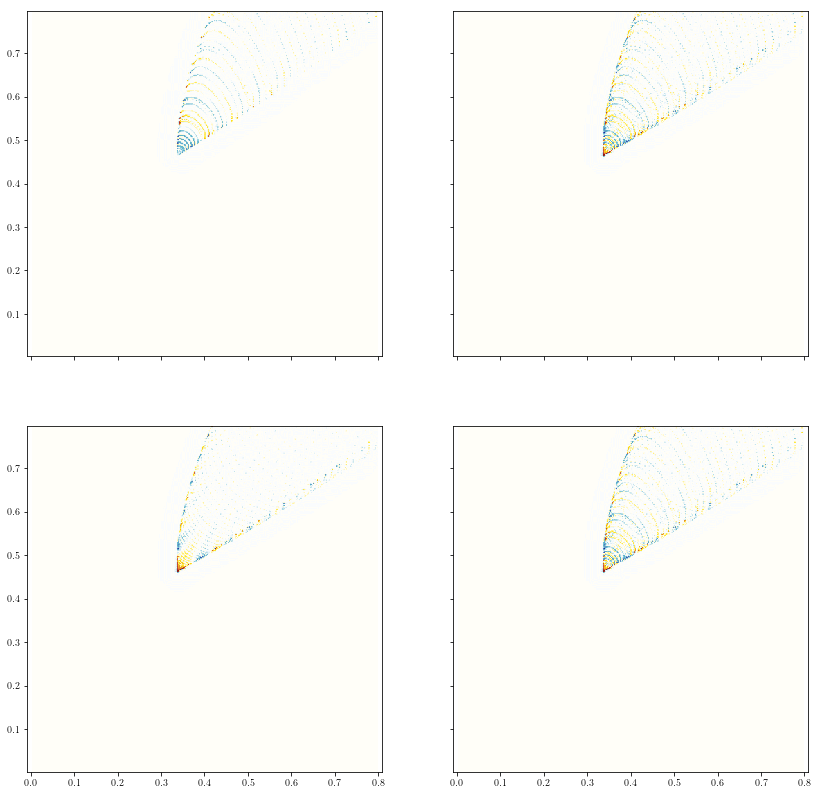

In [80]:
#usar la ruta apropiada para los .dat


fig, axarr = plt.subplots(2,2, sharex='col', sharey='row',figsize=(14,14));

x11, y11, z11 = np.genfromtxt(r'/Users/florez/tesis/python-codes/U_py_Diss_capa1.dat', unpack=True)
xl11 = x11.min();  xu11 = x11.max();  yl11 = y11.min();  yu11 = y11.max(); zl11 = z11.min(); zu11 = z11.max();
xi = np.linspace(xl11, xu11, N);
yi = np.linspace(yl11, yu11, N);
norm=plt.Normalize(-zu11,zu11)
zi = scipy.interpolate.griddata((x11, y11), z11, (xi[None,:], yi[:,None]), method='cubic',)
axarr[0,0].imshow(zi, extent=[xl11, xu11, yl11, yu11], origin='lower', 
                  cmap=GFTyMA, alpha=0.9, norm = norm)
#axarr[0,0].contour(xi, yi, zi, 8, alpha = 0.9, colors='black', linewidth=0.125)

x11, y11, z11 = np.genfromtxt(r'/Users/florez/tesis/python-codes/U_py_Diss_capa2.dat', unpack=True)
xl11 = x11.min();  xu11 = x11.max();  yl11 = y11.min();  yu11 = y11.max(); zl11 = z11.min(); zu11 = z11.max();
xi = np.linspace(xl11, xu11, N)
yi = np.linspace(yl11, yu11, N)
zi = scipy.interpolate.griddata((x11, y11), z11, (xi[None,:], yi[:,None]), method='cubic')
axarr[1,0].imshow(zi, extent=[xl11, xu11, yl11, yu11], origin='lower', 
                  cmap=GFTyMA, alpha=0.9, norm = norm)
#axarr[1,0].contour(xi, yi, zi, 8, alpha = 0.9, colors='black', linewidth=0.125)

x11, y11, z11 = np.genfromtxt(r'/Users/florez/tesis/python-codes/U_py_Diss_capa3.dat', unpack=True)
xl11 = x11.min();  xu11 = x11.max();  yl11 = y11.min();  yu11 = y11.max(); zl11 = z11.min(); zu11 = z11.max();
xi = np.linspace(xl11, xu11, N)
yi = np.linspace(yl11, yu11, N)
zi = scipy.interpolate.griddata((x11, y11), z11, (xi[None,:], yi[:,None]), method='cubic')
axarr[0,1].imshow(zi, extent=[xl11, xu11, yl11, yu11], origin='lower', 
                  cmap=GFTyMA,  alpha=0.9, norm = norm)
#axarr[0,1].contour(xi, yi, zi, 8, alpha = 0.9, colors='black', linewidth=0.125)
x11, y11, z11 = np.genfromtxt(r'/Users/florez/tesis/python-codes/U_py_Diss_capa3.dat', unpack=True)
xl11 = x11.min();  xu11 = x11.max();  yl11 = y11.min();  yu11 = y11.max(); zl11 = z11.min(); zu11 = z11.max();
xi = np.linspace(xl11, xu11, N)
yi = np.linspace(yl11, yu11, N)
zi = scipy.interpolate.griddata((x11, y11), z11, (xi[None,:], yi[:,None]), method='cubic')
axarr[1,1].imshow(zi, extent=[xl11, xu11, yl11, yu11], origin='lower', 
                  cmap=GFTyMA,  alpha=0.9, norm = norm)
                  
#axarr[1,1].contour(xi, yi, zi, 8, alpha = 0.9, colors='black', linewidth=0.125)